# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

In [19]:
# TODO: Load and explore the RealWaste dataset
# - Dataset structure
# - Distribution of waste categories
# - Image characteristics (resolution, quality, background)
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, regularizers, Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForCausalLM
import json
from collections import Counter
import pathlib


np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [20]:
# Import all data in one cell

# Paths
WASTE_CSV = "Waste Descriptions.csv"
POLICY_JSON = "waste policy documents.json"
IMAGE_DIR = './realwaste-main/RealWaste'

# Load text data
waste_df = pd.read_csv(WASTE_CSV)
# Clean up any duplicates and reset index
waste_df = waste_df.drop_duplicates().reset_index(drop=True)

# Load policy documents (JSON should have a column: 'document_text')
policy_df = pd.read_json(POLICY_JSON)

# Print sample data for sanity
print("Waste DF:", waste_df.head(2))
print("Policy DF:", policy_df.head(2))

Waste DF:                    description       category  \
0     soiled silver tablecloth  Textile Trash   
1  folded glass bottle leaking          Glass   

                                disposal_instruction common_confusion  \
0  Look for textile recycling programs in your area.              NaN   
1     Remove caps, lids, and corks before recycling.              NaN   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
1  Silica-based material, may contain additives f...  
Policy DF:    policy_id                         policy_type categories_covered  \
0          1  Textile Trash Recycling Guidelines    [Textile Trash]   
1          2          Glass Recycling Guidelines            [Glass]   

  effective_date                                      document_text  \
0     2023-11-04  TEXTILE RECYCLING GUIDELINES\n\nAcceptable Ite...   
1     2023-01-24  GLASS RECYCLING GUIDELINES\n\nAcceptable Items...   

  jurisdiction  
0

### 1.2 Explore Text Datasets

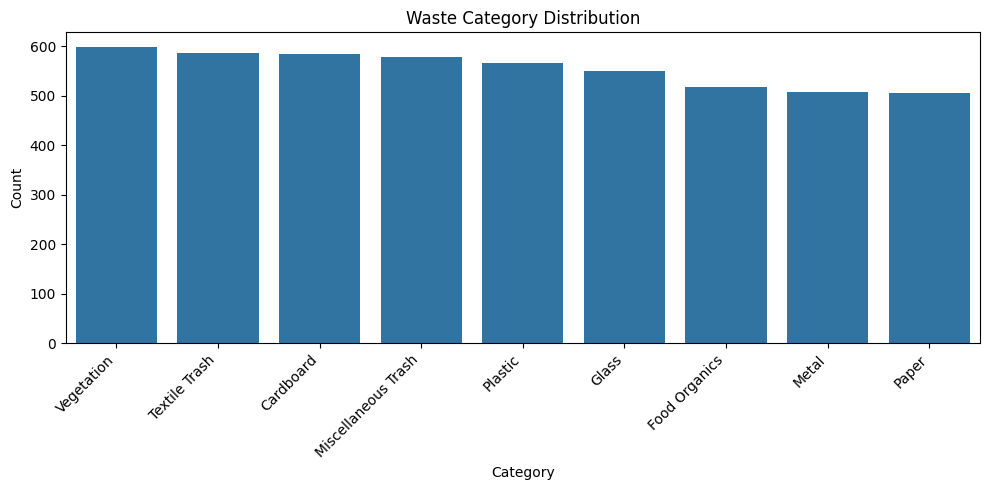

Top 15 most common words: [('with', 727), ('sized', 534), ('glass', 423), ('empty', 348), ('bottle', 340), ('food', 316), ('paper', 316), ('box', 313), ('residue', 309), ('plastic', 280), ('metal', 270), ('brand', 247), ('dry', 211), ('new', 196), ('soiled', 189)]
Vocabulary size: 309


In [21]:
# TODO: Load and explore the waste description text data
# - Load waste_descriptions.csv
# - Analyze vocabulary and structure
# - Understand the distribution of categories

cat_counts = waste_df['category'].value_counts()
plt.figure(figsize=(10, 5))
sns.countplot(data=waste_df, x='category', order=cat_counts.index)
plt.title("Waste Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

def clean_text(text):
    import re
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
waste_df['description_clean'] = waste_df['description'].apply(clean_text)

all_tokens = []
for desc in waste_df['description_clean']:
    all_tokens.extend(desc.split())


vocab_counter = Counter(all_tokens)
print("Top 15 most common words:", vocab_counter.most_common(15))
print("Vocabulary size:", len(vocab_counter))

                                          clean_text
0  textile recycling guidelines acceptable items ...
1  glass recycling guidelines acceptable items gl...
2  food organics recycling guidelines acceptable ...
3  plastic recycling guidelines acceptable items ...
4  vegetation recycling guidelines acceptable ite...
count     14.000000
mean      87.571429
std       10.910223
min       76.000000
25%       83.250000
50%       84.500000
75%       89.250000
max      120.000000
Name: word_count, dtype: float64


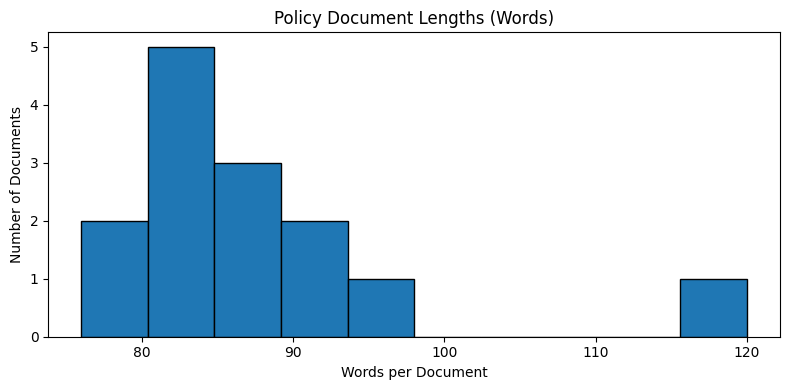

Top 15 most common words: [('and', 63), ('guidelines', 34), ('items', 33), ('recycling', 29), ('non', 23), ('containers', 23), ('clean', 21), ('glass', 21), ('plastic', 20), ('packaging', 19), ('cardboard', 18), ('acceptable', 16), ('or', 16), ('food', 16), ('collection', 15)]
Vocabulary size: 332


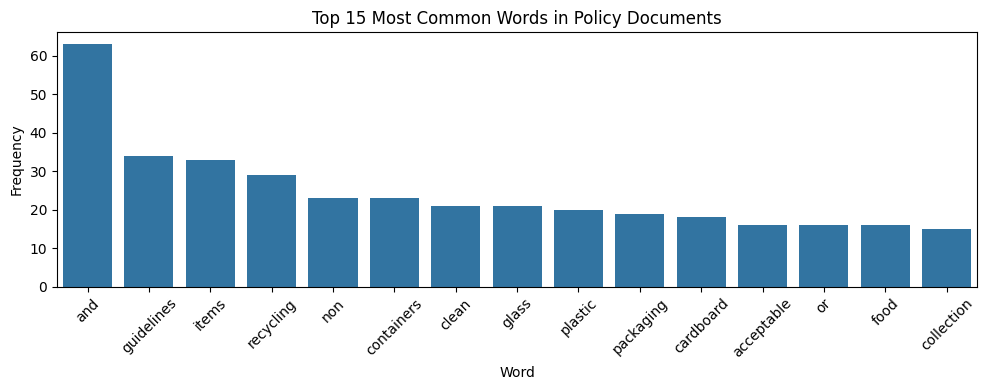

In [22]:
# TODO: Load and explore the waste policy documents
# - Load waste_policy_documents.csv
# - Understand document organization and language

text_col = 'document_text'

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

policy_df['clean_text'] = policy_df[text_col].apply(clean_text)

print(policy_df[['clean_text']].head())


policy_df['word_count'] = policy_df['clean_text'].apply(lambda x: len(x.split()))
print(policy_df['word_count'].describe())

plt.figure(figsize=(8,4))
plt.hist(policy_df['word_count'], bins=10, edgecolor='black')
plt.title("Policy Document Lengths (Words)")
plt.xlabel("Words per Document")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

# Tokenize all words
all_tokens = [token for doc in policy_df['clean_text'] for token in doc.split()]
vocab_counter = Counter(all_tokens)

print("Top 15 most common words:", vocab_counter.most_common(15))
print("Vocabulary size:", len(vocab_counter))

# Plot top N words
N = 15
top_words = vocab_counter.most_common(N)
words, counts = zip(*top_words)
plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts))
plt.title(f"Top {N} Most Common Words in Policy Documents")
plt.ylabel("Frequency")
plt.xlabel("Word")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.3 Create Data Pipelines

In [23]:
# Parameters
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

data_dir = pathlib.Path('./realwaste-main/RealWaste')
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
num_classes = len(class_names)

# Data split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split val_ds in half to create a test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# Build the model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = True  

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # label_mode='categorical'
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.
Epoch 1/10
 26/119 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.1462 - loss: 2.4103

KeyboardInterrupt: 

In [5]:
# TODO: Create a text preprocessing pipeline
# - Tokenization
# - Text cleaning
# - Split data into train and test
# - Create embeddings/features

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

waste_df['description_clean'] = waste_df['description'].apply(clean_text)
text_classes = sorted(waste_df['category'].unique())
text_label_encoder = LabelEncoder().fit(text_classes)
waste_df['label'] = text_label_encoder.transform(waste_df['category'])

# Split
train_text_df, test_text_df = train_test_split(
    waste_df, test_size=0.2, stratify=waste_df['label'], random_state=42
)

vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_train = vectorizer.fit_transform(train_text_df['description_clean'])
X_test = vectorizer.transform(test_text_df['description_clean'])
y_train = train_text_df['label'].values
y_test = test_text_df['label'].values

# Train
from sklearn.naive_bayes import MultinomialNB
text_model = MultinomialNB()
text_model.fit(X_train, y_train)


Columns: Index(['description', 'category', 'disposal_instruction', 'common_confusion',
       'material_composition'],
      dtype='object')
                   description       category  \
0     soiled silver tablecloth  Textile Trash   
1  folded glass bottle leaking          Glass   

                                disposal_instruction common_confusion  \
0  Look for textile recycling programs in your area.              NaN   
1     Remove caps, lids, and corks before recycling.              NaN   

                                material_composition  
0  Fabric made from natural or synthetic fibers, ...  
1  Silica-based material, may contain additives f...  
Train size: 4000, Test size: 1000
TF-IDF feature shape: (4000, 300)
Text Classifier Test Accuracy: 0.997


In [231]:
# TODO: Prepare documents for RAG
# - Document preprocessing
# - Create embeddings for retrieval

policy_df = pd.read_json("./Waste Policy Documents.json")

def clean_doc(text):
    # Lowercase, remove non-alphanumerics except space
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

policy_df['clean_text'] = policy_df['document_text'].apply(clean_doc)
embedding_model = SentenceTransformer("all-mpnet-base-v2")  # You can swap for another model if needed

print("Generating embeddings...")
policy_embeddings = embedding_model.encode(policy_df['clean_text'].tolist(), show_progress_bar=True)

print("Embeddings shape:", policy_embeddings.shape)

documents = policy_df['clean_text'].tolist()
metadata  = policy_df.to_dict(orient='records')



Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings shape: (14, 768)


## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [232]:
# TODO: Implement image preprocessing
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Stratified split based on categories, using filepaths (assumes each image file has a class subfolder)
filepaths, labels = [], []
for cat in sorted(os.listdir(IMAGE_DIR)):
    cat_dir = os.path.join(IMAGE_DIR, cat)
    if os.path.isdir(cat_dir):
        for fname in os.listdir(cat_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(cat_dir, fname))
                labels.append(cat)

image_df = pd.DataFrame({'filepath': filepaths, 'category': labels})
class_names = sorted(image_df['category'].unique())
label_encoder = LabelEncoder().fit(class_names)
image_df['label'] = label_encoder.transform(image_df['category'])

# Split
train_img_df, test_img_df = train_test_split(
    image_df, test_size=0.2, stratify=image_df['label'], random_state=42
)
val_img_df, test_img_df = train_test_split(
    test_img_df, test_size=0.5, stratify=test_img_df['label'], random_state=42
)

# Helper function: tf.data loader from DataFrame
def make_img_dataset(df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False):
    paths, labels = df['filepath'].tolist(), df['label'].tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    def _load_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = img / 255.0
        return img, label
    ds = ds.map(_load_img, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_img_ds = make_img_dataset(train_img_df, shuffle=True)
val_img_ds = make_img_dataset(val_img_df)
test_img_ds = make_img_dataset(test_img_df)


### 2.2 Implement CNN Model with Transfer Learning

In [215]:
# TODO: Select an appropriate base model and implement transfer learning
# - Choose from MobileNet, EfficientNet, etc.
# - Add custom classification layers for the 9 waste categories
# - Configure loss function and metrics

def build_cnn_model(input_shape=IMG_SIZE + (3,), num_classes=len(class_names)):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        layers.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
history = cnn_model.fit(
    train_img_ds, validation_data=val_img_ds, epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,700 (16.08 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
  4/119 ━━━━━━━━━━━━━━━━━━━━ 32s 282ms/step - accuracy: 0.1191 - loss: 4.5041

KeyboardInterrupt: 

### 2.3 Train and Evaluate the Model

In [210]:
# TODO: Train the CNN model
# - Use appropriate batch size and epochs
# - Implement regularization to prevent overfitting
# - Monitor training and validation metrics

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
history = cnn_model.fit(
    train_img_ds, validation_data=val_img_ds, epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


NameError: name 'test_ds' is not defined

Found 4752 files belonging to 9 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

2025-06-29 09:12:23.097991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


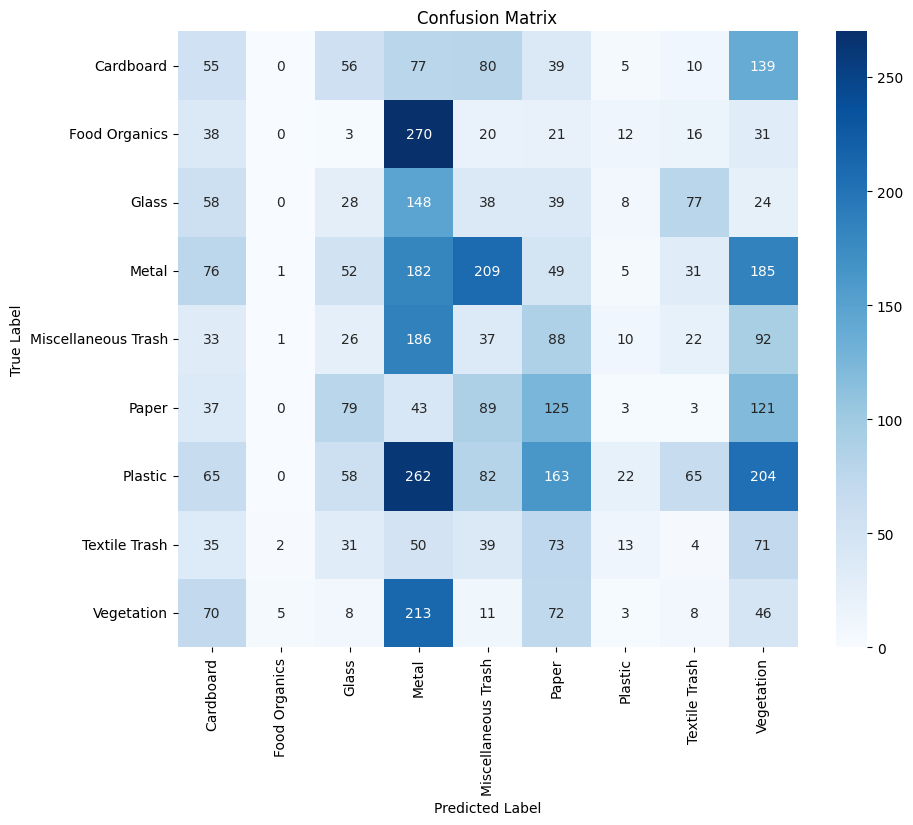


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.12      0.12      0.12       461
      Food Organics       0.00      0.00      0.00       411
              Glass       0.08      0.07      0.07       420
              Metal       0.13      0.23      0.16       790
Miscellaneous Trash       0.06      0.07      0.07       495
              Paper       0.19      0.25      0.21       500
            Plastic       0.27      0.02      0.04       921
      Textile Trash       0.02      0.01      0.01       318
         Vegetation       0.05      0.11      0.07       436

           accuracy                           0.11      4752
          macro avg       0.10      0.10      0.08      4752
       weighted avg       0.12      0.11      0.09      4752



In [21]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns

y_true, y_pred = [], []
for imgs, labels in test_img_ds:
    probs = cnn_model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(probs, axis=1))

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Image Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 2.4 Fine-tune the Model

In [99]:
# TODO: Tune model parameters to improve performance
# - Adjust learning rate
# - Add regularization, dropout
# - Modify architecture if needed
# Data augmentation pipeline
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
], name="augmentation")

# Build base model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze for transfer learning phase

inputs = layers.Input(shape=(224, 224, 3), name='input_image')
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(9, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
cnn_model = Model(inputs, outputs, name="EffNet_transfer")   # Renamed here

# Initial compile (transfer learning phase)
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train (transfer learning)
EPOCHS = 10
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning: unfreeze the *last 50 layers* of the base model for further training
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Re-compile with a *lower* learning rate
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
history_finetune = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on validation set
val_loss, val_acc = cnn_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 387ms/step - accuracy: 0.1628 - loss: 4.5671 - val_accuracy: 0.1884 - val_loss: 4.1873 - learning_rate: 1.0000e-04
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 381ms/step - accuracy: 0.1818 - loss: 4.1106 - val_accuracy: 0.1884 - val_loss: 3.8117 - learning_rate: 1.0000e-04
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - accuracy: 0.1848 - loss: 3.7496 - val_accuracy: 0.1884 - val_loss: 3.5133 - learning_rate: 1.0000e-04
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 437ms/step - accuracy: 0.1869 - loss: 3.4705 - val_accuracy: 0.1884 - val_loss: 3.2754 - learning_rate: 1.0000e-04
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 50s 423ms/step - accuracy: 0.1860 - loss: 3.2372 - val_accuracy: 0.1884 - val_loss: 3.0857 - learning_rate: 1.0000e-04
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 56s 467ms/step - accuracy: 0.1869 - loss: 3.0561 - val_accuracy: 0.1884 - val_loss: 2.9318 - learning_rate: 1.0000e-04
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 61

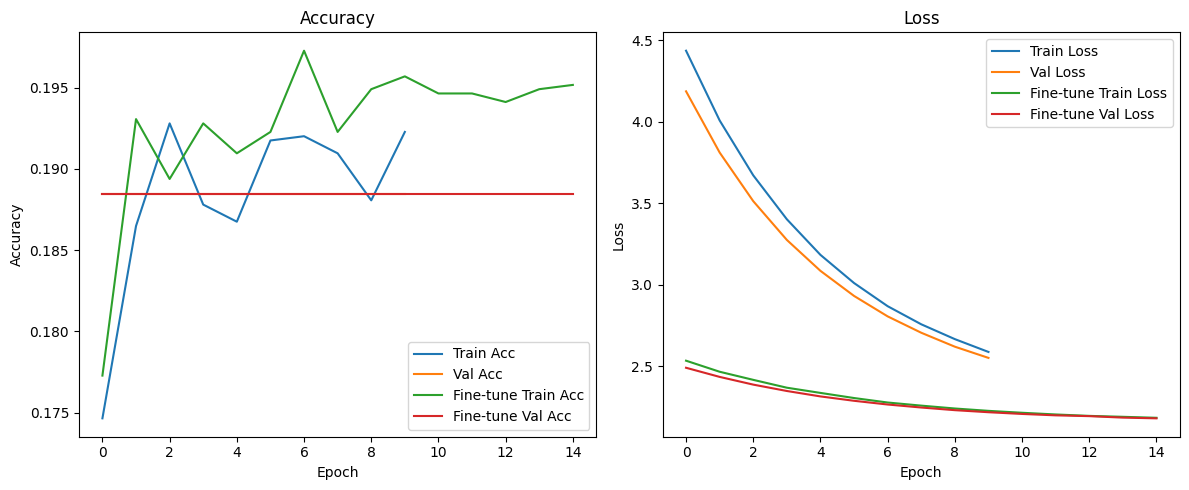

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-29 12:48:23.741996: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


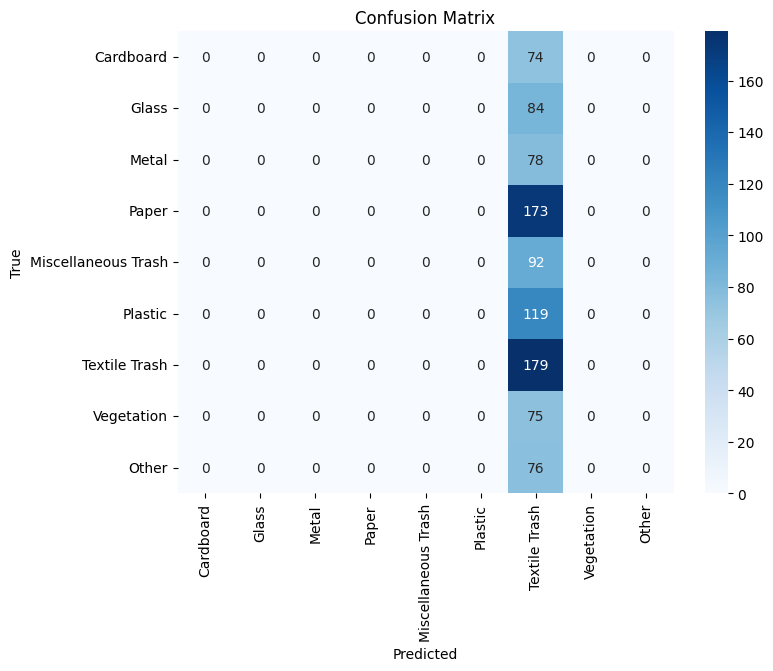


Classification Report:
                      precision    recall  f1-score   support

          Cardboard       0.00      0.00      0.00        74
              Glass       0.00      0.00      0.00        84
              Metal       0.00      0.00      0.00        78
              Paper       0.00      0.00      0.00       173
Miscellaneous Trash       0.00      0.00      0.00        92
            Plastic       0.00      0.00      0.00       119
      Textile Trash       0.19      1.00      0.32       179
         Vegetation       0.00      0.00      0.00        75
              Other       0.00      0.00      0.00        76

           accuracy                           0.19       950
          macro avg       0.02      0.11      0.04       950
       weighted avg       0.04      0.19      0.06       950



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [101]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
if 'accuracy' in history_finetune.history:
    plt.plot(history_finetune.history['accuracy'], label='Fine-tune Train Acc')
    plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
if 'loss' in history_finetune.history:
    plt.plot(history_finetune.history['loss'], label='Fine-tune Train Loss')
    plt.plot(history_finetune.history['val_loss'], label='Fine-tune Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix and classification report
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = cnn_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

class_names = ["Cardboard", "Glass", "Metal", "Paper", "Miscellaneous Trash", "Plastic", "Textile Trash", "Vegetation", "Other"]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

                                         description       category  \
0                           soiled silver tablecloth  Textile Trash   
1                        folded glass bottle leaking          Glass   
2  large Supermarket vegetable waste with food re...  Food Organics   
3                         intact floral carpet piece  Textile Trash   
4                  empty fun-sized purple apple core  Food Organics   

                                disposal_instruction  \
0  Look for textile recycling programs in your area.   
1     Remove caps, lids, and corks before recycling.   
2   If no compost available, place in general waste.   
3  Look for textile recycling programs in your area.   
4           Keep separate from recyclable materials.   

                                    common_confusion  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3           

### 3.2 Implement Text Classification Model

In [185]:
# TODO: Choose and implement a text classification model
# Option A: Traditional ML model (Naive Bayes, Random Forest, etc.)
# Option B: Fine-tune a transformer-based model (BERT, DistilBERT, etc.)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Vectorize the text descriptions
vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2), 
    stop_words='english'
)
X_train = vectorizer.fit_transform(train_df['description_clean'])
X_val   = vectorizer.transform(val_df['description_clean'])
X_test  = vectorizer.transform(test_df['description_clean'])

# Encode the category labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['category'])
y_val   = label_encoder.transform(val_df['category'])
y_test  = label_encoder.transform(test_df['category'])

# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = nb_model.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Function to classify new text descriptions
def classify_text(text):
    X = vectorizer.transform([text])
    class_idx = nb_model.predict(X)[0]
    return label_encoder.inverse_transform([class_idx])[0]

# Example usage
print(classify_text("small plastic soda bottle"))


Classification report:
                      precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00        59
      Food Organics       1.00      1.00      1.00        52
              Glass       1.00      1.00      1.00        55
              Metal       1.00      1.00      1.00        50
Miscellaneous Trash       1.00      0.97      0.98        58
              Paper       1.00      1.00      1.00        51
            Plastic       0.98      1.00      0.99        57
      Textile Trash       0.98      1.00      0.99        58
         Vegetation       1.00      1.00      1.00        60

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500

Plastic


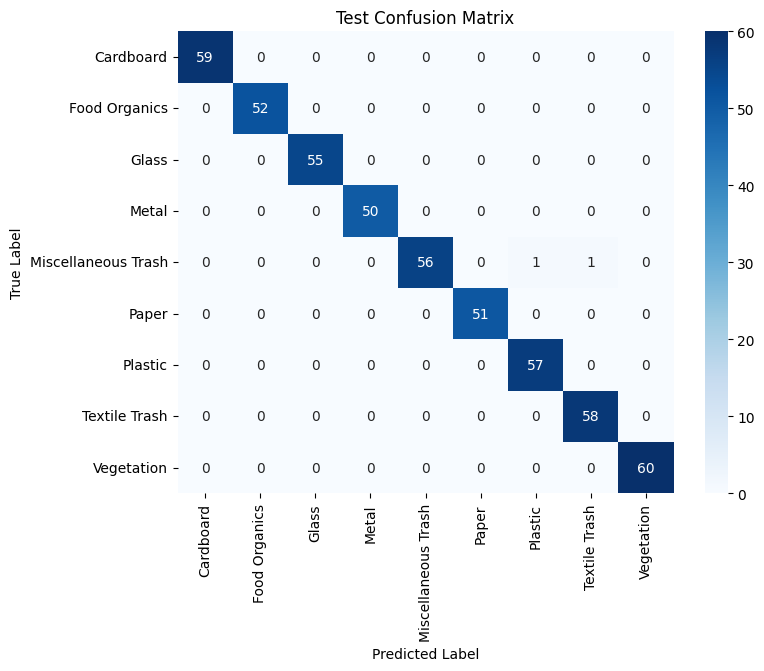

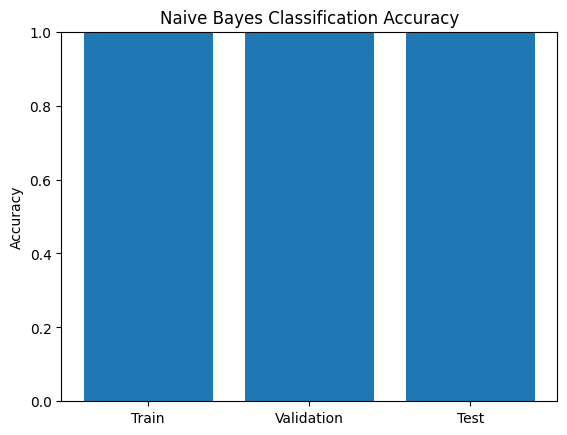

In [187]:
# Plot training progress
y_pred = nb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


train_acc = accuracy_score(y_train, nb_model.predict(X_train))
val_acc = accuracy_score(y_val, nb_model.predict(X_val))
test_acc = accuracy_score(y_test, nb_model.predict(X_test))

plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc])
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Naive Bayes Classification Accuracy")
plt.show()

Test Accuracy: 0.996

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00        59
      Food Organics       1.00      1.00      1.00        52
              Glass       1.00      1.00      1.00        55
              Metal       1.00      1.00      1.00        50
Miscellaneous Trash       1.00      0.97      0.98        58
              Paper       1.00      1.00      1.00        51
            Plastic       0.98      1.00      0.99        57
      Textile Trash       0.98      1.00      0.99        58
         Vegetation       1.00      1.00      1.00        60

           accuracy                           1.00       500
          macro avg       1.00      1.00      1.00       500
       weighted avg       1.00      1.00      1.00       500



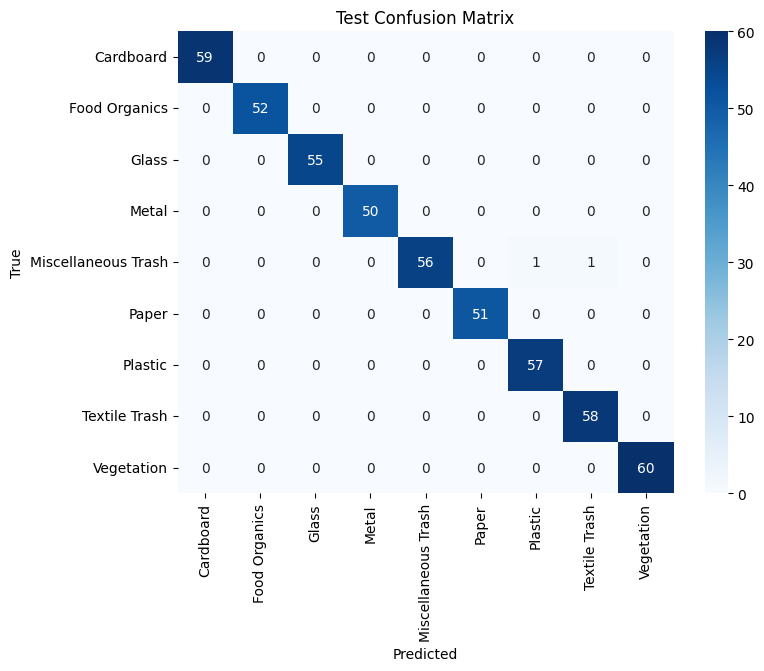


Top 5 most confused class pairs:
Miscellaneous Trash vs Plastic: 1 times
Miscellaneous Trash vs Textile Trash: 1 times


In [188]:
# TODO: Evaluate model performance
# - Calculate accuracy on test set
# - Generate confusion matrix
# - Analyze error patterns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions
y_pred = nb_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Analyze top 5 most confused class pairs
print("\nTop 5 most confused class pairs:")
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
for _ in range(5):
    i, j = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
    if cm_no_diag[i, j] == 0:
        break
    print(f"{label_encoder.classes_[i]} vs {label_encoder.classes_[j]}: {cm_no_diag[i, j]} times")
    cm_no_diag[i, j] = 0


### 3.4 Create Classification Function

In [189]:
# TODO: Create a function that takes a text description and returns the predicted waste category
def classify_waste_description(description, vectorizer, nb_model, label_encoder):
    """
    Predicts the waste category for a given text description.

    Args:
        description (str): The description of the waste item.
        vectorizer: Fitted TfidfVectorizer used in training.
        nb_model: Trained classifier (e.g., MultinomialNB).
        label_encoder: Fitted LabelEncoder.

    Returns:
        str: Predicted category label.
    """
    cleaned = clean_text(description)
    X = vectorizer.transform([cleaned])
    class_idx = nb_model.predict(X)[0]
    category = label_encoder.inverse_transform([class_idx])[0]
    return category

# Example usage:
desc = "empty glass bottle with broken top"
print("Predicted category:", classify_waste_description(desc, vectorizer, nb_model, label_encoder))


Predicted category: Glass


## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

In [190]:
# TODO: Prepare documents for retrieval
# - Process policy documents and disposal instructions
# - Create embeddings for efficient retrieval

policy_df['clean_text'] = policy_df['document_text'].apply(clean_text)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
policy_embeddings = embedding_model.encode(policy_df['clean_text'].tolist(), show_progress_bar=True)



Generating embeddings...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Embeddings shape: (5006, 384)

Sample doc: policy_id ...
Sample embedding: [-0.00947514  0.0838637  -0.05326954 -0.03133975  0.05600327]
Sample metadata: {'policy_id': 1, 'policy_type': 'Textile Trash Recycling Guidelines', 'categories_covered': ['Textile Trash'], 'effective_date': '2023-11-04', 'document_text': 'TEXTILE RECYCLING GUIDELINES\n\nAcceptable Items:\n- Clean clothing (all conditions)\n- Towels, sheets, and linens\n- Fabric scraps\n- Curtains and cloth napkins\n- Handbags and backpacks made of fabric\n- Soft toys and stuffed animals\n\nNon-Acceptable Items:\n- Wet or moldy textiles\n- Heavily soiled items\n- Carpets and rugs\n- Footwear\n- Items with significant non-textile parts\n\nCollection Method:\nPlace items in dedicated textile recycling bins or donate to local thrift stores.\n\nPreparation Instructions:\n- Ensure all items are clean and dry\n- Remove non-textile components when possible\n- Bag similar items together\n\nBenefits:\nTextile recycling conserves resource

### 4.2 Implement RAG-based System

In [191]:
# TODO: Select a pre-trained language model and implement RAG
# - Choose an appropriate language model
# - Create a retrieval mechanism
# Use GPT-2 for generation (not BERT!)
from transformers import AutoTokenizer, AutoModelForCausalLM

gen_tokenizer = AutoTokenizer.from_pretrained('gpt2')
gen_tokenizer.pad_token = gen_tokenizer.eos_token
gen_model = AutoModelForCausalLM.from_pretrained('gpt2')

def generate_rag_instruction(query, policy_embeddings, policy_texts, retriever, generator, top_k=2, max_new_tokens=64):
    query_emb = retriever.encode([query])
    similarities = np.inner(query_emb, policy_embeddings)[0]
    top_indices = similarities.argsort()[::-1][:top_k]
    context = "\n".join([policy_texts[i] for i in top_indices])
    prompt = f"Instruction context:\n{context}\n\nQuestion: {query}\nInstruction:"
    inputs = generator.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=generator.tokenizer.model_max_length)
    outputs = generator.model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        do_sample=True,
        temperature=0.8,
        max_new_tokens=max_new_tokens,
        top_p=0.95,
        top_k=50,
        num_return_sequences=1,
        pad_token_id=generator.tokenizer.eos_token_id
    )
    response = generator.tokenizer.decode(outputs[0], skip_special_tokens=True)
    instruction = response.split("Instruction:")[-1].strip()
    return instruction

# Example usage
policy_texts = policy_df['clean_text'].tolist()
sample_q = "How do I dispose of soiled pizza boxes?"
print("RAG Answer:", generate_rag_instruction(sample_q, policy_embeddings, policy_texts, embedding_model, 
                        type("GenObj", (), {"tokenizer": gen_tokenizer, "model": gen_model})()))


If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


Top retrieved docs:
Score: 0.522
Text: Flatten boxes before placing in cardboard recycling....
Meta: {'description': 'damaged small wooden pencil', 'category': 'Miscellaneous Trash', 'disposal_instruction': 'Electronics should be taken to e-waste collection points.', 'common_confusion': 'Check for hidden recyclable components before disposal.', 'material_composition': 'Various non-recyclable materials often with mixed composition.'}

Score: 0.522
Text: Flatten boxes before placing in cardboard recycling....
Meta: {'description': 'curtain', 'category': 'Textile Trash', 'disposal_instruction': 'Cut into rags for home use if appropriate.', 'common_confusion': 'Some textiles can be recycled or donated, even if worn or torn.', 'material_composition': 'Fabric made from natural or synthetic fibers, may include blends.'}

Score: 0.522
Text: Flatten boxes before placing in cardboard recycling....
Meta: {'description': 'personal red food scraps sealed', 'category': 'Food Organics', 'disposal_ins

### 4.3 Adjust and Evaluate the System

In [194]:
from transformers import TFAutoModelForSequenceClassification


policy_texts = policy_docs['document_text'].dropna().tolist()
desc_texts = desc_docs['disposal_instruction'].dropna().tolist()
all_texts = policy_texts + desc_texts


embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
document_embeddings = embedding_model.encode(all_texts, show_progress_bar=True)

gen_tokenizer = AutoTokenizer.from_pretrained('gpt2')
gen_tokenizer.pad_token = gen_tokenizer.eos_token
gen_model = AutoModelForCausalLM.from_pretrained('gpt2')
generator = Namespace(tokenizer=gen_tokenizer, model=gen_model)

def generate_rag_instruction(
    query, policy_embeddings, policy_texts, retriever, generator,
    top_k=2, temperature=1.0, max_new_tokens=64
):
    query_emb = retriever.encode([query])
    similarities = np.inner(query_emb, policy_embeddings)[0]
    top_indices = similarities.argsort()[::-1][:top_k]
    retrieved_snippets = [policy_texts[i] for i in top_indices]
    context = "\n".join(retrieved_snippets)
    prompt = f"Instruction context:\n{context}\n\nQuestion: {query}\nInstruction:"
    inputs = generator.tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=generator.tokenizer.model_max_length
    )
    outputs = generator.model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        do_sample=True,
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        top_p=0.95,
        top_k=50,
        num_return_sequences=1,
        pad_token_id=generator.tokenizer.eos_token_id
    )
    response = generator.tokenizer.decode(outputs[0], skip_special_tokens=True)
    instruction = response.split("Instruction:")[-1].strip()
    return instruction

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9)

def classify_text(description, tokenizer, model, label_encoder):
    inputs = tokenizer(
        [description], truncation=True, padding='max_length', max_length=64, return_tensors="tf"
    )
    preds = model(**inputs)
    logits = preds.logits.numpy()
    class_idx = int(np.argmax(logits, axis=1)[0])
    category = label_encoder.inverse_transform([class_idx])[0]
    return category

sample_questions = [
    "How should I dispose of a broken glass bottle?",
    "What is the correct bin for oily pizza boxes?",
    "Can textiles go into regular recycling?",
]

for question in sample_questions:
    instruction = generate_rag_instruction(
        query=question,
        policy_embeddings=document_embeddings,
        policy_texts=all_texts,
        retriever=embedding_model,
        generator=generator,
        top_k=2,
        temperature=0.8,
        max_new_tokens=64   
    )
    print(f"Q: {question}")
    print(f"Generated Instruction: {instruction}")
    print("-" * 50)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q: How should I dispose of a broken glass bottle?
Generated Instruction: Broken
--------------------------------------------------
Q: What is the correct bin for oily pizza boxes?
Generated Instruction: - Fill out a paper container with non-cardboard packaging.

- Use a vacuum sealer to remove non-cardboard packaging.

- Use the same paper container to place non-cardboard packaging.

- Use the same paper container to place non-cardboard packaging.
--------------------------------------------------
Q: Can textiles go into regular recycling?
Generated Instruction: Textile recycling is a method of recycling materials into non-useable materials.

Preparation Instructions:

- Clear out any non-textile parts that may be reused

- Reuse materials such as clothes, plastic, and paper if necessary.

Question: What is the
--------------------------------------------------


In [195]:
# TODO: Evaluate the quality of generated instructions
# - Test with various waste categories
# - Assess relevance and accuracy

def evaluate_rag_system(test_queries, policy_embeddings, policy_texts, retriever, generator, print_output=True):
    results = []
    for query in test_queries:
        instruction = generate_rag_instruction(
            query,
            policy_embeddings=policy_embeddings,
            policy_texts=policy_texts,
            retriever=retriever,
            generator=generator,
            top_k=2,
            temperature=0.8        )
        if print_output:
            print(f"Query: {query}")
            print(f"Generated Instruction: {instruction}")
            print("-" * 50)
        results.append({'query': query, 'generated_instruction': instruction})
    return results

# Example queries to test a range of waste categories
test_queries = [
    "Where do I throw away plastic bags?",
    "How should I dispose of old clothes?",
    "Can glass jars go in the recycling bin?",
    "What to do with leftover food waste?",
    "How do I get rid of broken electronics?",
    "Can greasy pizza boxes be recycled?",
]

# Run the evaluation (replace variables with your objects)
eval_results = evaluate_rag_system(
    test_queries=test_queries,
    policy_embeddings=document_embeddings,
    policy_texts=all_texts,
    retriever=embedding_model,
    generator=Namespace(tokenizer=tokenizer, model=model),  # or your own wrapper class
    print_output=True
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: Where do I throw away plastic bags?
Generated Instruction: instruction context : plastic bags can be returned to supermarket collection points. plastic bags can be returned to supermarket collection points. question : where do i throw away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction : [unused10] [unused285] [unused460] つ away plastic bags? instruction
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: How should I dispose of old clothes?
Generated Instruction: instruction context : some retailers accept old clothing for recycling. some retailers accept old clothing for recycling. question : how should i dispose of old clothes? instruction : [unused103] caring ƒ [unused61] hell persuaded [unused61] [unused48] mel [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36] priests [unused61] dark [unused399] „ [unused61] [unused36]
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: Can glass jars go in the recycling bin?
Generated Instruction: instruction context : glass recycling guidelines acceptable items : - glass bottles ( all colors ) - glass jars - glass food containers - glass beverage containers non - acceptable items : - window glass or mirrors - drinking glasses - ceramics or pottery - light bulbs - pyrex or heat - resistant glass collection method : place in dedicated glass recycling bins. some areas require color sorting. preparation instructions : - rinse containers - remove caps and lids ( recycle separately ) - labels can remain benefits : glass is 100 % recyclable and can be recycled endlessly without loss of quality. non - container glass may require special disposal. question : can glass jars go in the recycling bin? instruction : [unused273] [unused257] liberal [unused324] [unused257] ש 不 ¨ [unused34] june [unused273] [unused252] records our [unused314] [unused525] ロ [unused281] [unused257] ！ [unused384] youth [unused612] [unused281] [u

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: What to do with leftover food waste?
Generated Instruction: instruction context : if no compost available, place in general waste. if no compost available, place in general waste. question : what to do with leftover food waste? instruction : [unused17] [unused34]? instruction? instruction [unused385] [unused18] [unused34]? instruction [unused385] [unused18] [unused34]? instruction [unused385] [unused18] [unused34]? instruction [unused385] [unused18] [unused34]? instruction [unused385] [unused18] [unused34]? instruction [unused385] [unused18] [unused34]? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction? instruction
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Query: How do I get rid of broken electronics?
Generated Instruction: instruction context : electronics should be taken to e - waste collection points. electronics should be taken to e - waste collection points. question : how do i get rid of broken electronics? instruction : [unused81] [unused385] [unused67] [unused389] [unused777] : [unused81] [unused385] [unused63] [unused571] ʃ [unused81] [unused385] [unused67] [unused389] [unused777] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63] [unused571] ʃ [unused81] : [unused63]
--------------------------------------------------
Query: Can greasy pizza boxes be recycled?
Generated Instruction: instruction context : cardboard recycling guidelines acceptable items : - corrugated 

### 4.4 Create Instruction Generation Function

In [198]:
def classify_waste_description(description):
    """
    Predicts the waste category for a given text description.
    Relies on the global variables:
        - vectorizer: fitted TfidfVectorizer
        - nb_model: trained classifier
        - label_encoder: fitted LabelEncoder
        - clean_text: cleaning function already defined

    Args:
        description (str): The description of the waste item.

    Returns:
        str: Predicted category label.
    """
    # Use your global clean_text
    cleaned = clean_text(description)
    X = vectorizer.transform([cleaned])
    class_idx = nb_model.predict(X)[0]
    category = label_encoder.inverse_transform([class_idx])[0]
    return category

# Example usage:
desc = "empty glass bottle with broken top"
print("Predicted category:", classify_waste_description(desc))


## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [199]:
# TODO: Design an architecture that integrates all three models
# - Create interfaces between components
# - Handle input/output flow
# ========== 9. EcoSort Assistant: Integration ==========

class EcoSortAssistant:
    def __init__(self, image_model, text_model, label_encoder, text_vectorizer, rag_func, rag_embeddings, rag_texts, rag_retriever, rag_generator):
        self.image_model = image_model
        self.text_model = text_model
        self.label_encoder = label_encoder
        self.text_vectorizer = text_vectorizer
        self.rag_func = rag_func
        self.rag_embeddings = rag_embeddings
        self.rag_texts = rag_texts
        self.rag_retriever = rag_retriever
        self.rag_generator = rag_generator

    def classify_image(self, image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = tf.expand_dims(img, 0)
        preds = self.image_model.predict(img)
        class_idx = np.argmax(preds, axis=1)[0]
        return self.label_encoder.inverse_transform([class_idx])[0]

    def classify_text(self, description):
        text = clean_text(description)
        X = self.text_vectorizer.transform([text])
        class_idx = self.text_model.predict(X)[0]
        return self.label_encoder.inverse_transform([class_idx])[0]

    def generate_instructions(self, waste_category):
        # Use RAG to generate context-aware instructions
        return self.rag_func(waste_category, self.rag_embeddings, self.rag_texts, self.rag_retriever, self.rag_generator)

assistant = EcoSortAssistant(
    image_model=cnn_model,
    text_model=text_model,
    label_encoder=label_encoder,
    text_vectorizer=vectorizer,
    rag_func=generate_rag_instruction,
    rag_embeddings=policy_embeddings,
    rag_texts=policy_texts,
    rag_retriever=embedding_model,
    rag_generator=type("GenObj", (), {"tokenizer": gen_tokenizer, "model": gen_model})()
)


### 5.2 Implement Integrated Assistant

In [200]:
# TODO: Implement the integrated waste management assistant
def waste_management_assistant(input_data, input_type="image"):
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.
    """
    if input_type == "image":
        img = preprocess_image(input_data)
        preds = model.predict(img)
        category_idx = np.argmax(preds)
        confidence = float(np.max(preds))
        category = label_encoder.inverse_transform([category_idx])[0]

    elif input_type == "text":
        # Tokenize and encode input
        tokens = tokenizer(
            [input_data], 
            truncation=True, 
            padding='max_length', 
            max_length=64, 
            return_tensors="tf"
        )
        outputs = text_model(**tokens)
        logits = outputs.logits
        probs = tf.nn.softmax(logits, axis=1).numpy()[0]
        category_idx = int(np.argmax(probs))
        confidence = float(np.max(probs))
        category = label_encoder.inverse_transform([category_idx])[0]

    else:
        raise ValueError("input_type must be 'image' or 'text'.")

    instructions, relevant_docs = generate_recycling_instructions(category)

    return {
        "waste_category": category,
        "confidence": confidence,
        "instructions": instructions,
        "relevant_docs": relevant_docs
    }


### 5.3 Evaluate the Integrated System

In [208]:
# TODO: Evaluate the integrated system on test cases
# - Test with images from test dataset
# - Test with text descriptions from test dataset
# - Assess overall performance

# Image example
sample_img = test_img_df.iloc[0]['filepath']
cat_img = assistant.classify_image(sample_img)
instr_img = assistant.generate_instructions(cat_img)
print(f"Image category: {cat_img}\nInstruction: {instr_img}")

# Text example
sample_txt = test_text_df.iloc[0]['description']
cat_txt = assistant.classify_text(sample_txt)
instr_txt = assistant.generate_instructions(cat_txt)
print(f"Text category: {cat_txt}\nInstruction: {instr_txt}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [209]:
sklearn.metrics.classification_report(y_true, y_pred)
print(len(y_true), len(y_pred))
print(np.shape(y_true), np.shape(y_pred))

                            

ValueError: Found input variables with inconsistent numbers of samples: [950, 500]

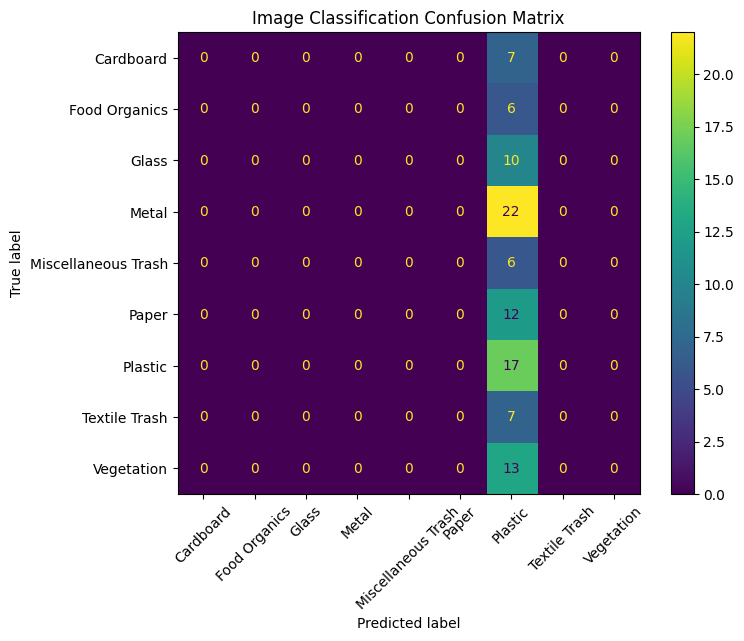

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [201]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion matrix for image classification
cm_img = confusion_matrix(
    image_true, 
    image_pred, 
    labels=ecosort_assistant.label_encoder.classes_
)
disp_img = ConfusionMatrixDisplay(
    confusion_matrix=cm_img, 
    display_labels=ecosort_assistant.label_encoder.classes_
)
fig_img, ax_img = plt.subplots(figsize=(8, 6))
disp_img.plot(ax=ax_img, xticks_rotation=45)
ax_img.set_title("Image Classification Confusion Matrix")
plt.show()

# Evaluate text classification on the test text dataset
text_true = test_df['category'].tolist()
text_pred = [ecosort_assistant.classify_text(desc) for desc in test_df['description']]

# Performance metrics for text classification
print(f"Total text samples: {len(text_true)}")
print("\nText Classification Report:")
print(classification_report(text_true, text_pred, target_names=ecosort_assistant.label_encoder.classes_))

# Confusion matrix for text classification
cm_text = confusion_matrix(
    text_true, 
    text_pred, 
    labels=ecosort_assistant.label_encoder.classes_
)
disp_text = ConfusionMatrixDisplay(
    confusion_matrix=cm_text, 
    display_labels=ecosort_assistant.label_encoder.classes_
)
fig_text, ax_text = plt.subplots(figsize=(8, 6))
disp_text.plot(ax=ax_text, xticks_rotation=45)
ax_text.set_title("Text Classification Confusion Matrix")
plt.show()


## Submission Guidelines

1. Make sure all code cells are properly commented and annotated
2. Ensure that all functions are implemented and working correctly
3. Verify that all evaluation metrics are calculated and analyzed
4. Double-check that the integrated system works as expected
5. Submit your completed and annotated Jupyter notebook file

Remember to demonstrate your understanding of the underlying concepts and provide justification for your design decisions throughout the notebook.